In [274]:
# Install required Python packages
# You can uncomment and run these lines if you haven't installed them yet.
# !pip install scanpy squidpy anndata pandas matplotlib seaborn scikit-learn

# Import necessary libraries
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture

# For visualization
import matplotlib.patches as mpatches


In [275]:
# Load 10X Genomics Visium spatial transcriptomics data
#adata = sq.datasets.visium_fluo("knee")  # if you have your own data path, use `sq.read.visium`

# Alternatively, load your local data (matches R code path)
adata = sq.read.visium(path="knee_spatial_python/knee", load_images=True)

# Basic overview
print(adata)


C:\Users\abuhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\abuhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2072 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\1695148888.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=None, title="All Spots")


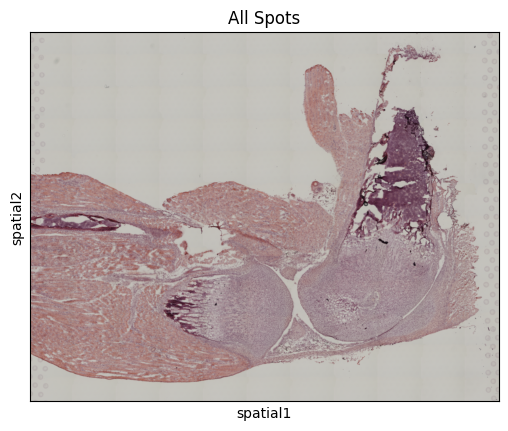

In [276]:
# Plot the tissue section with spatial spots
sc.pl.spatial(adata, img_key="hires", color=None, title="All Spots")


In [277]:
# Load expert annotations
annotations = pd.read_csv("knee_spatial_python/knee/GP_features_1_Slide_1_A_WTM_Results_GP_ann.csv")

# Clean and standardize labels
annotations["GP"] = annotations["GP"].replace({
    "chondrocytes": "chondrocyte",
    "pre-osteo": "pre-osteoblast",
    "pre-osteoblasr": "pre-osteoblast",
    "secondary hypertophic": "secondary hypertrophic"
})

# Add the cleaned annotation to the AnnData object metadata
adata.obs["Expert_Annotation"] = annotations["GP"].values


C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\2628280721.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


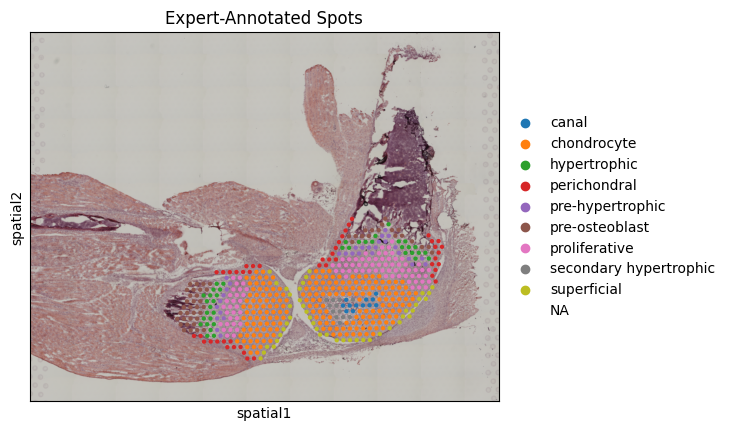

In [278]:
# Plot spatial expression colored by expert annotation
sc.pl.spatial(
    adata,
    img_key="hires",
    color="Expert_Annotation",
    size=1.0,
    title="Expert-Annotated Spots"
)


C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\2912577174.py:5: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


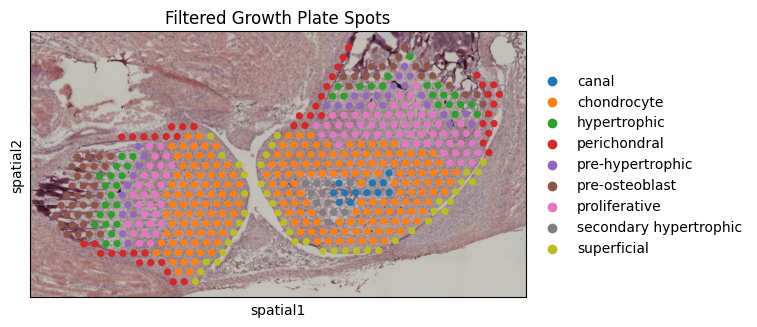

In [279]:
# Filter out spots with no expert annotation
adata = adata[adata.obs["Expert_Annotation"].notna() & (adata.obs["Expert_Annotation"] != ""), :]

# Plot again to confirm
sc.pl.spatial(
    adata,
    img_key="hires",
    color="Expert_Annotation",
    size=1.0,
    title="Filtered Growth Plate Spots"
)


In [280]:
adata.var_names[adata.var_names.duplicated()].unique()


Index(['Ptp4a1', 'Arhgef4', 'Sept2', 'Zc3h11a', 'Gm16701', 'Pakap', 'Gm28710',
       'Jakmip1', 'Fam220a', 'Gm16499', 'Olfr290', 'Aldoa', 'Dpep2', 'Gm16364',
       'C730027H18Rik', 'Ddit3', 'St6galnac2', 'Gm35558', 'Ighv5-8',
       'Ighv1-13', 'Nnt', 'Gm5089', '4930594M22Rik', 'Gm41392', 'Gm38619',
       'Snhg4', 'Pcdha11', 'Gm35438', 'Btbd35f1', 'Fam90a1b', 'Ccl21b',
       'Fam205a4', 'Gm3286', 'Il11ra2', 'Ccl27a', 'Ccl21c', 'Ccl19', 'Ccl21a'],
      dtype='object')

C:\Users\abuhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


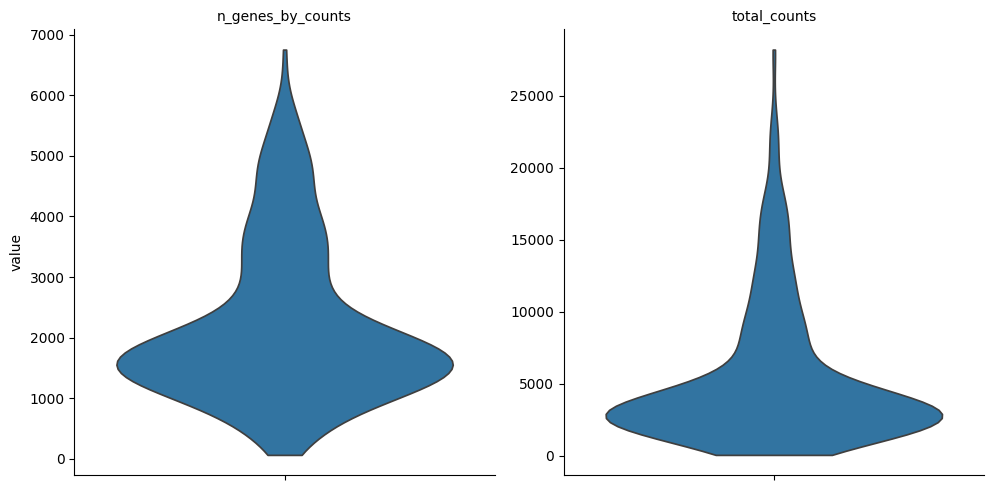

In [281]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure unique gene names (needed to prevent errors in Scanpy)
adata.var_names_make_unique()

# Compute QC metrics if not already present
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Plot violin plots for n_genes and total_counts per spot
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
    rotation=45,
    stripplot=False,
    show=True
)


### Interpretation:

- Most spots should show ~1500–4000 genes and ~2000–10000 total counts.
- Outliers with very low or very high values may represent poor-quality data (e.g., dead cells, empty spots, or ambient RNA contamination).
- This visualization will help define thresholds for filtering low-quality spots.


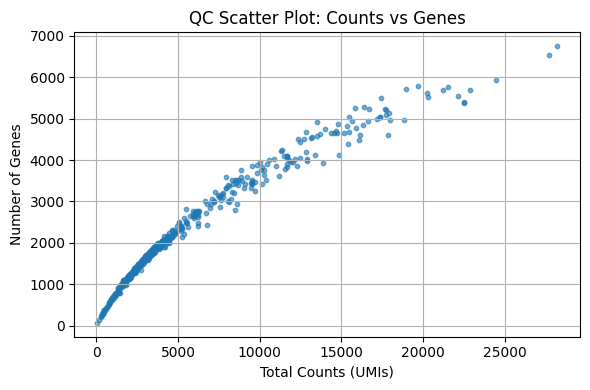

In [282]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure gene names are unique
adata.var_names_make_unique()

# Calculate QC metrics if not already done
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Plot scatter using matplotlib directly, as Scanpy doesn't support arbitrary x/y obs keys
plt.figure(figsize=(6, 4))
plt.scatter(
    adata.obs['total_counts'],
    adata.obs['n_genes_by_counts'],
    s=10,
    alpha=0.6
)
plt.xlabel('Total Counts (UMIs)')
plt.ylabel('Number of Genes')
plt.title('QC Scatter Plot: Counts vs Genes')
plt.grid(True)
plt.tight_layout()
plt.show()


In [283]:
import numpy as np

r = np.corrcoef(
    adata.obs['total_counts'],
    adata.obs['n_genes_by_counts']
)[0, 1]
print(f"Pearson correlation: r = {r:.2f}")


Pearson correlation: r = 0.97


### Interpretation:

- A strong positive correlation (e.g., r ≈ 0.97) is expected.
- Most spots follow this trend — higher RNA content leads to more gene diversity.
- Outlier points that deviate may represent technical artifacts or low-quality spots.


In [284]:
# Step-by-step SCTransform-like normalization
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # Save raw log-normalized data

# Filter out non-finite genes before HVG detection
valid_genes = np.isfinite(adata.X.mean(axis=0)).A1 if hasattr(adata.X, 'A1') else np.isfinite(adata.X.mean(axis=0))
adata = adata[:, valid_genes]

# Detect highly variable genes (Scanpy’s Seurat-like method)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

# Optional: restrict downstream analysis to HVGs only
adata = adata[:, adata.var.highly_variable]


C:\Users\abuhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\preprocessing\_highly_variable_genes.py:703: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


### SCTransform Equivalent in Scanpy

- Normalization to 10,000 counts per spot standardizes for sequencing depth.
- Log1p transformation stabilizes variance, similar to Seurat’s SCTransform.
- Highly variable gene selection ensures dimensionality reduction uses informative features.


C:\Users\abuhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\preprocessing\_pca\__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


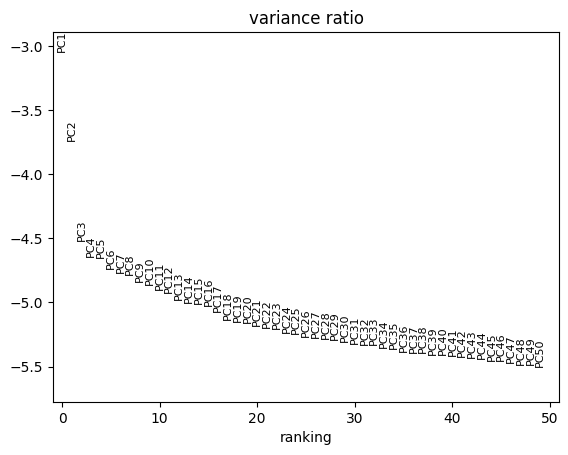

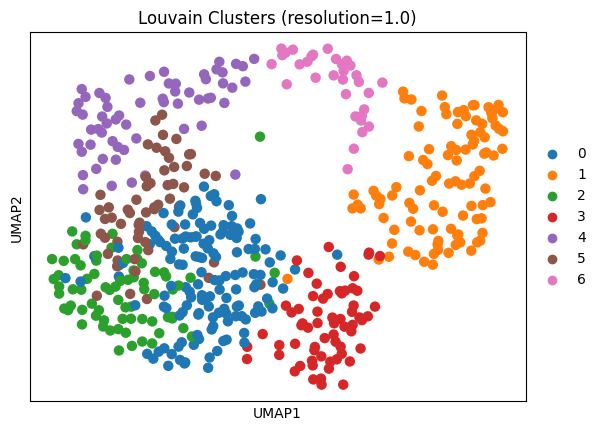

In [285]:
import scanpy as sc

# PCA on log-normalized, HVG-filtered data
sc.tl.pca(adata, svd_solver='arpack')

# Plot PCA variance ratio (scree plot) — optional but useful
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

# Build nearest neighbor graph (like Seurat's FindNeighbors)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

# Louvain clustering (like Seurat's FindClusters)
sc.tl.louvain(adata, resolution=1.0)

# UMAP for visualization (like RunUMAP)
sc.tl.umap(adata)

# Plot UMAP colored by Louvain clusters
sc.pl.umap(adata, color='louvain', title="Louvain Clusters (resolution=1.0)")


C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\2155150150.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


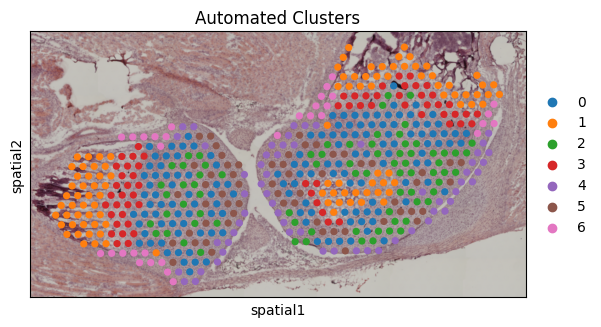

In [286]:
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt


# Spatial plot colored by clusters
# Equivalent to: SpatialDimPlot(group.by = "cluster")
# ---------------------------------------------
sc.pl.spatial(
    adata,
    img_key="hires",              # Use high-resolution tissue image
    color="louvain",              # Show cluster assignments
    title="Automated Clusters",
    size=1.0,                     # Adjust dot size as needed
    show=True
)


### Interpretation:

- This plot shows spatial transcriptomics clusters (0–4 or more) overlaid on the tissue image.
- These clusters were discovered based purely on gene expression — no expert annotation used.
- You can now compare these clusters with biological regions for validation.


In [287]:
import scanpy as sc
import pandas as pd

# Run differential expression test across all Expert_Annotation groups
# Equivalent to: FindAllMarkers(group.by = "Expert_Annotation")
sc.tl.rank_genes_groups(
    adata,
    groupby="Expert_Annotation",
    method="wilcoxon",        # Statistical method
    use_raw=True,             # Use normalized expression
    pts=True                  # Report fraction of cells expressing the gene
)


1. View top five marker genes

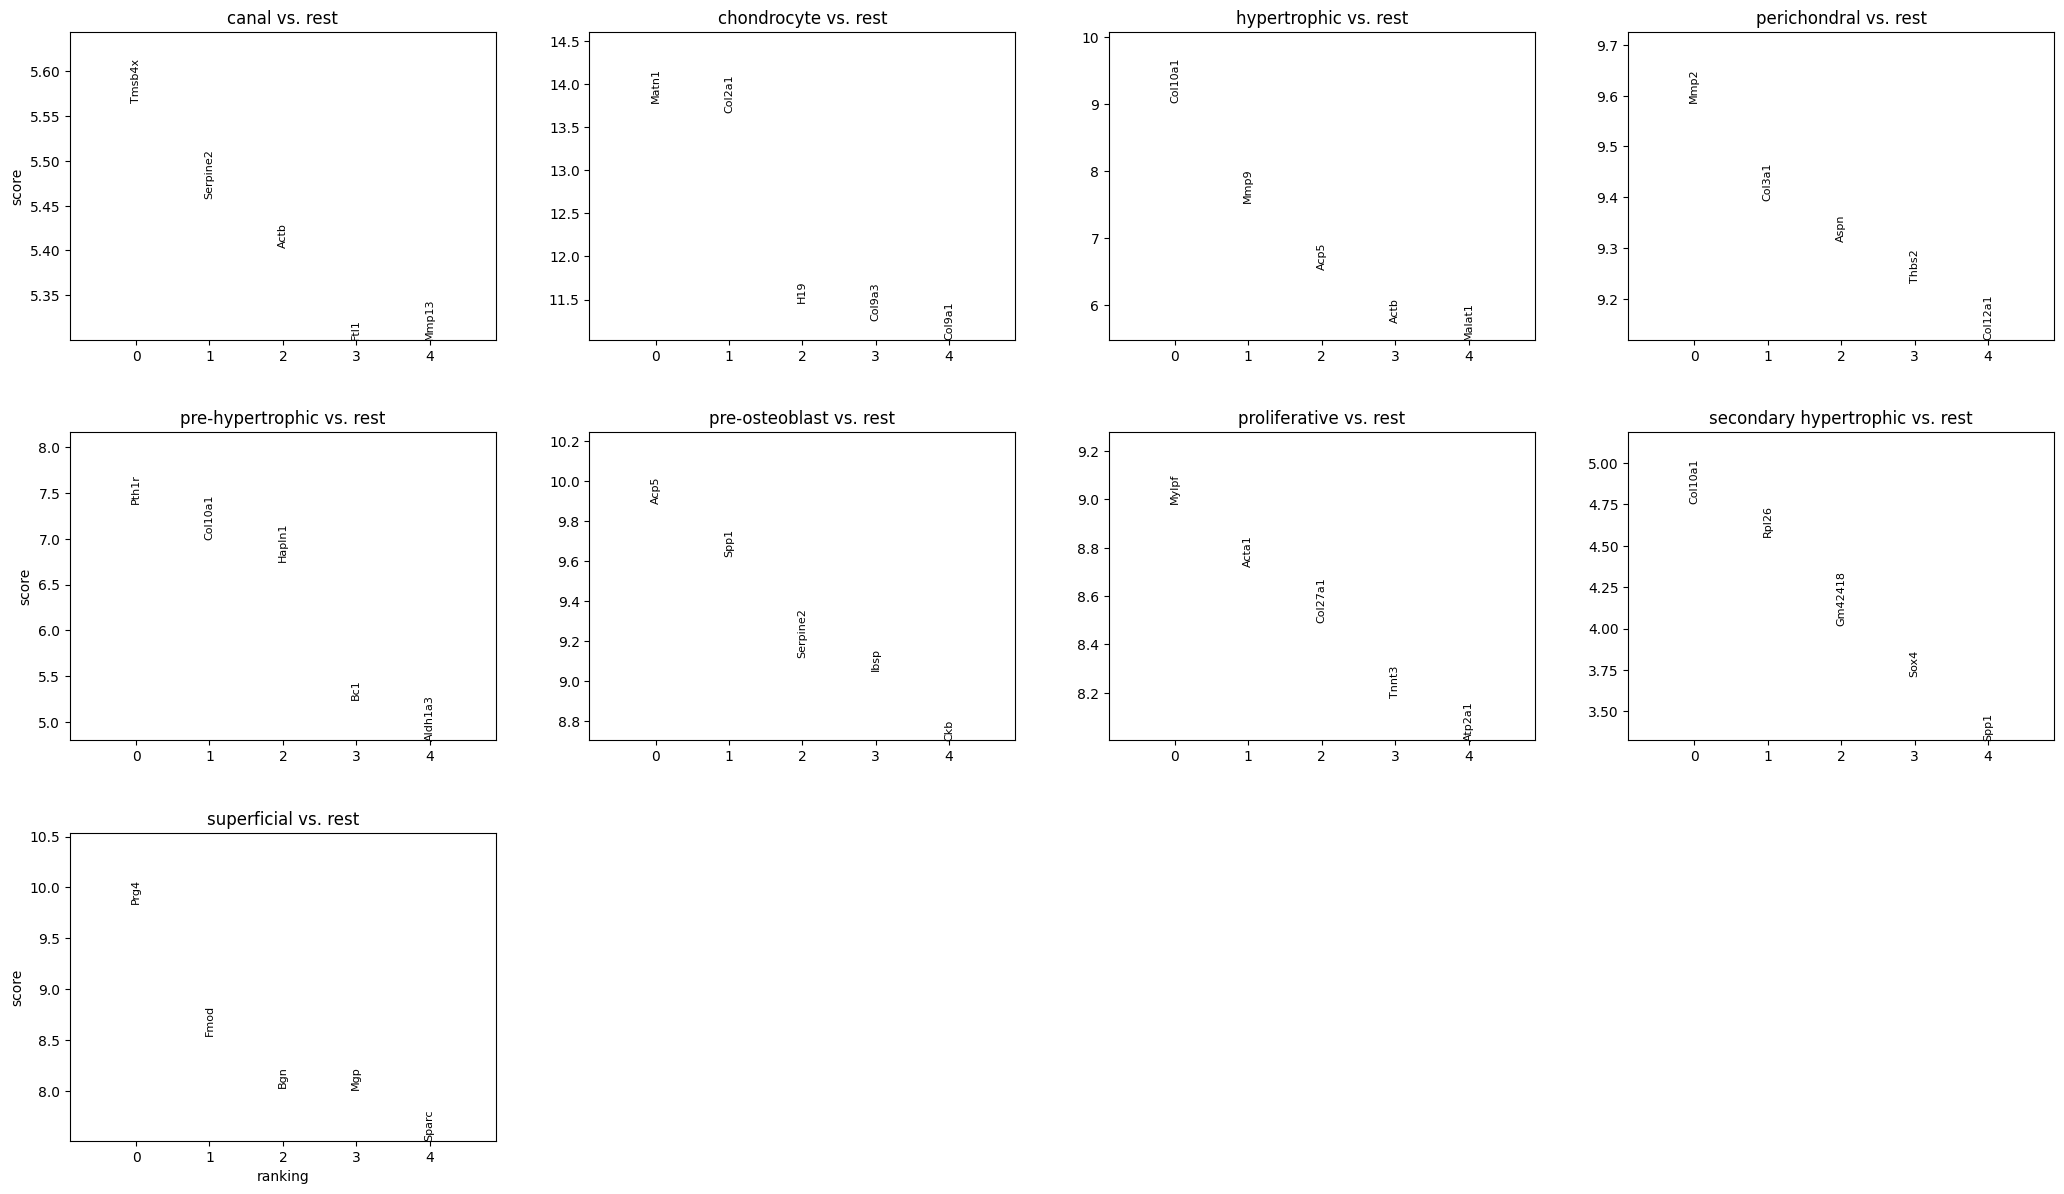

In [288]:
# View top genes per expert annotation
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


2. Export DEGs to CSV (for use in figures or reports)

In [289]:
degs = sc.get.rank_genes_groups_df(adata, group=None)  # All groups
degs['gene_base'] = degs['names'].str.replace(r'\.\d+$', '', regex=True)
degs.to_csv("Expert_Annotation_DEGs.csv", index=False)


3. Visualize top spatial markers

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\2616299861.py:5: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


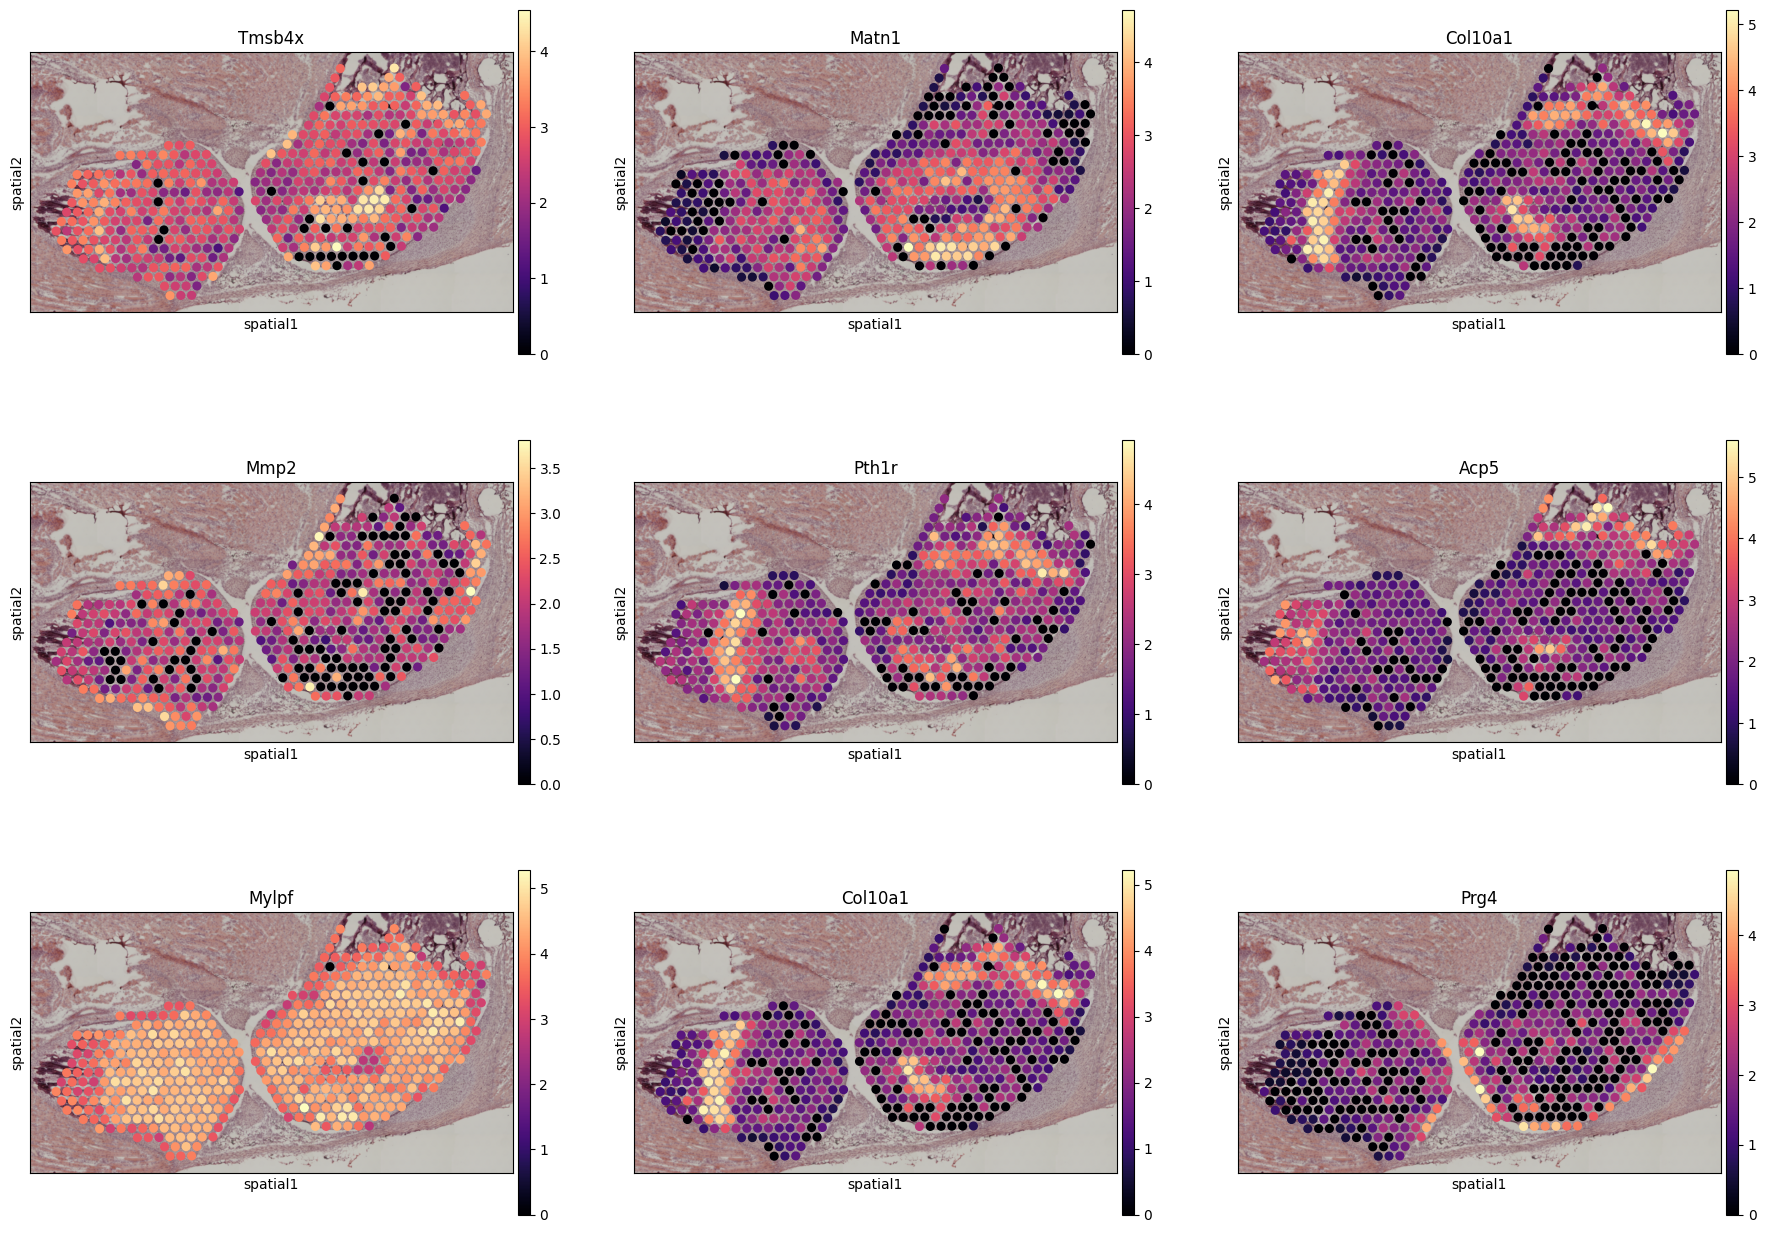

In [290]:
# Example: plot top marker for each expert annotation
top_genes = degs.groupby("group")["names"].first().tolist()

# Spatial expression plots
sc.pl.spatial(
    adata,
    color=top_genes,
    img_key="hires",
    ncols=3,
    size=1.3,
    cmap="magma"
)


4. (Optional) Compare DEGs with Louvain clusters

In [291]:
sc.tl.rank_genes_groups(adata, groupby="louvain", method="wilcoxon")


Plot marker genes:

Provided code focuses on specific biologically relevant genes related to our research question.

In [292]:
import scanpy as sc
import squidpy as sq
import pandas as pd

# ---------------------------------------------------------
# 1. Differential Expression for Louvain Clusters
# Equivalent to: FindAllMarkers(slide1)
# ---------------------------------------------------------
sc.tl.rank_genes_groups(
    adata,
    groupby="louvain",           # Automated clustering result
    method="wilcoxon",
    use_raw=True,
    pts=True
)

# Store results in a DataFrame
deg_all = sc.get.rank_genes_groups_df(adata, group=None)
deg_all['gene_base'] = deg_all['names'].str.replace(r'\.\d+$', '', regex=True)


C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\1807509152.py:10: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


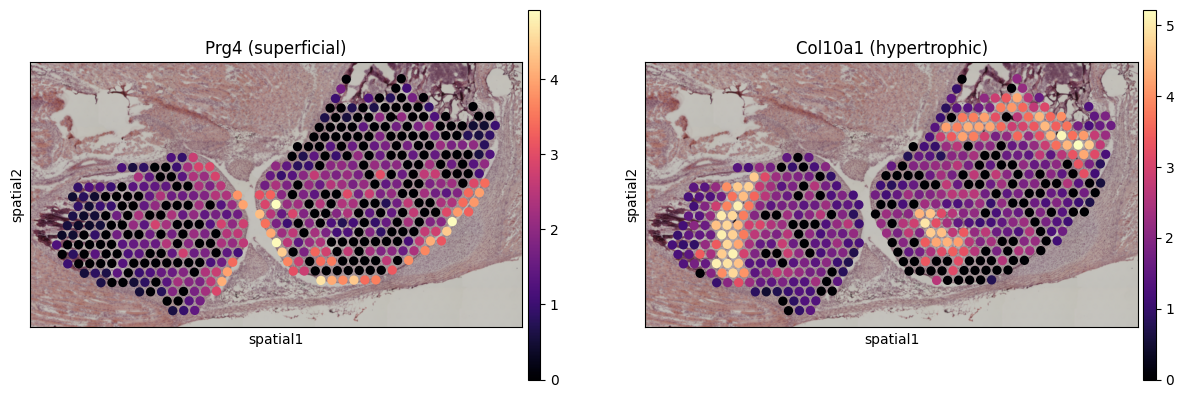

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\1807509152.py:21: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


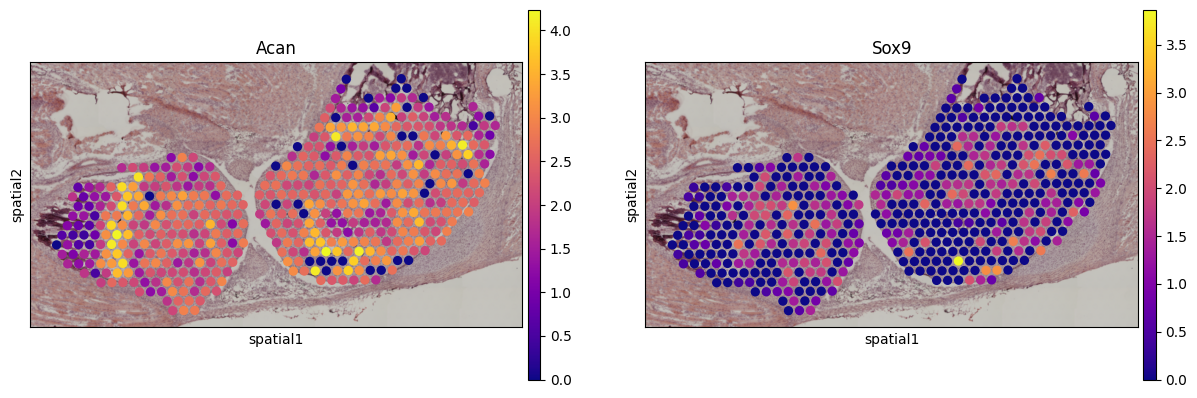

In [293]:
# Define genes of interest
genes_of_interest_Primary = ["Prg4", "Col10a1"]
genes_of_interest_Secondary = ["Acan", "Sox9"]

# ---------------------------------------------------------
# 2. Spatial Feature Plots (like SpatialFeaturePlot in R)
# ---------------------------------------------------------

# Plot primary markers
sc.pl.spatial(
    adata,
    color=genes_of_interest_Primary,
    img_key="hires",
    ncols=2,
    size=1.3,
    cmap="magma",
    title=["Prg4 (superficial)", "Col10a1 (hypertrophic)"]
)

# Plot secondary markers
sc.pl.spatial(
    adata,
    color=genes_of_interest_Secondary,
    img_key="hires",
    ncols=2,
    size=1.3,
    cmap="plasma",
    title=["Acan", "Sox9"]
)


### Interpretation of Spatial Markers

- **Prg4**:
  - Strongly expressed near tissue edges, marking superficial cartilage zones.
  - Key role in joint lubrication and surface homeostasis (Pawlak 2019, Matsushita 2017).
- **Col10a1**:
  - Localized to central/deep tissue zones.
  - Marker of hypertrophic chondrocytes in ossifying cartilage (Han 2024, Limpach 2006).
- **Acan** and **Sox9**:
  - Co-expressed in cartilage-forming regions.
  - Acan for extracellular matrix, Sox9 as a master chondrogenic transcription factor.


Compare the expert annotations to the clustering results:

Provided code compares automated clusters with expert annotations, a key requirement for your poster assignment.

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\2789487842.py:16: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


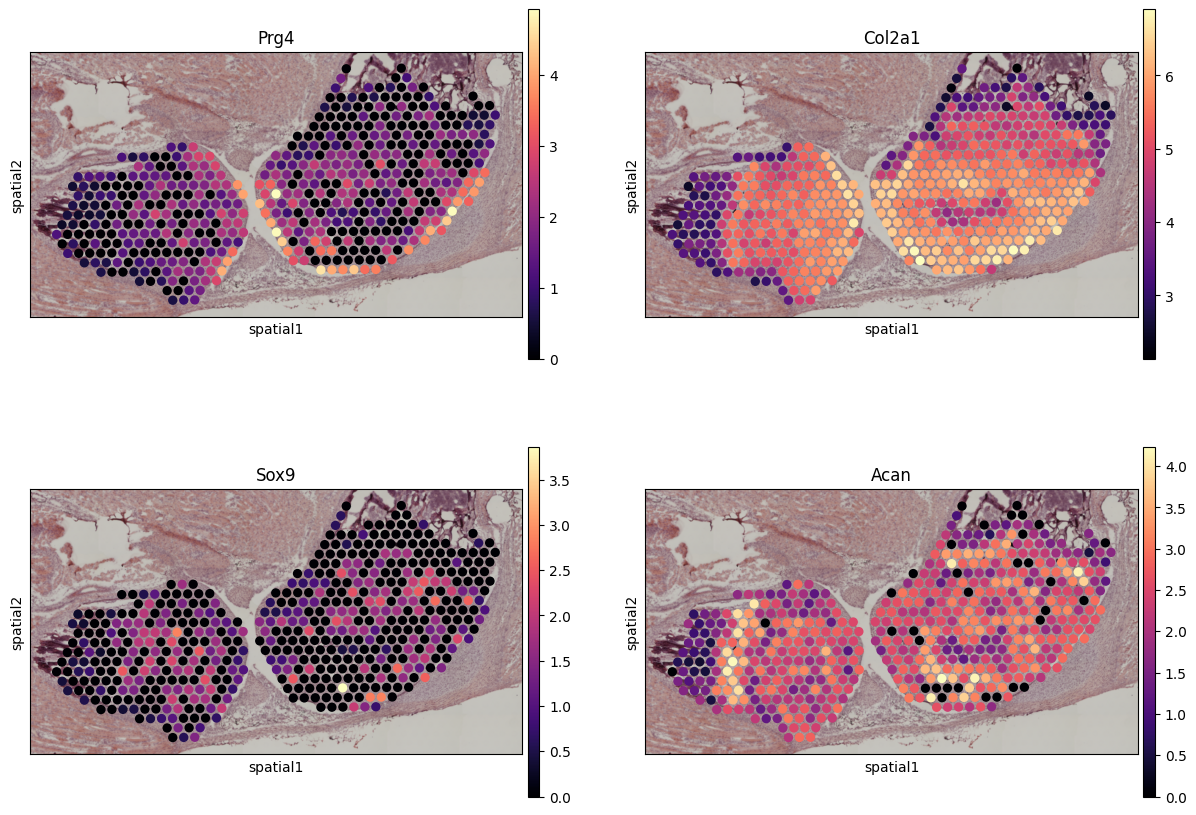

In [294]:
import scanpy as sc
import squidpy as sq
import pandas as pd

# ----------------------------------------------------
# Define genes based on prior biological knowledge
# ----------------------------------------------------
selected_genes = ["Prg4", "Col2a1", "Sox9", "Acan"]

# If we have DEG results and want to clean gene names:
degs['gene_base'] = degs['names'].str.replace(r'\.\d+$', '', regex=True)

# ----------------------------------------------------
# Spatial Feature Plots for Prior-Knowledge Genes
# ----------------------------------------------------
sc.pl.spatial(
    adata,
    color=selected_genes,
    img_key="hires",
    ncols=2,
    size=1.3,
    cmap="magma",
    title=selected_genes
)


### Spatial Expression of Biologically Relevant Genes

- **Prg4**: Marker for superficial cartilage zones.
- **Col2a1 & Acan**: Highlight cartilage extracellular matrix structure.
- **Sox9**: Key transcription factor regulating chondrocyte differentiation and maintaining cartilage identity (Han et al. 2024; Haseeb et al. 2021).

These spatial patterns reflect tissue specialization and align with known cartilage biology.


1. Adjust color scales per gene

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\3185300570.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


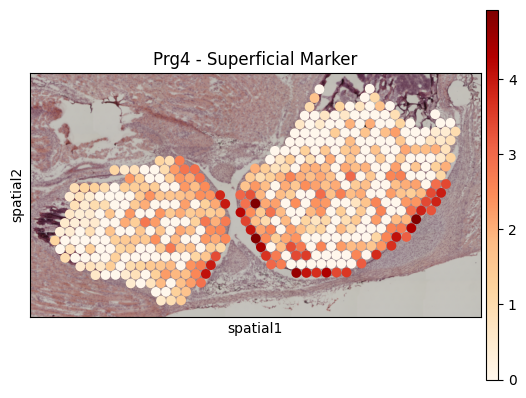

In [295]:
sc.pl.spatial(
    adata,
    color=["Prg4"],
    img_key="hires",
    cmap="OrRd",
    size=1.5,
    title="Prg4 - Superficial Marker"
)


2. Save figures for reports

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\1985921541.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


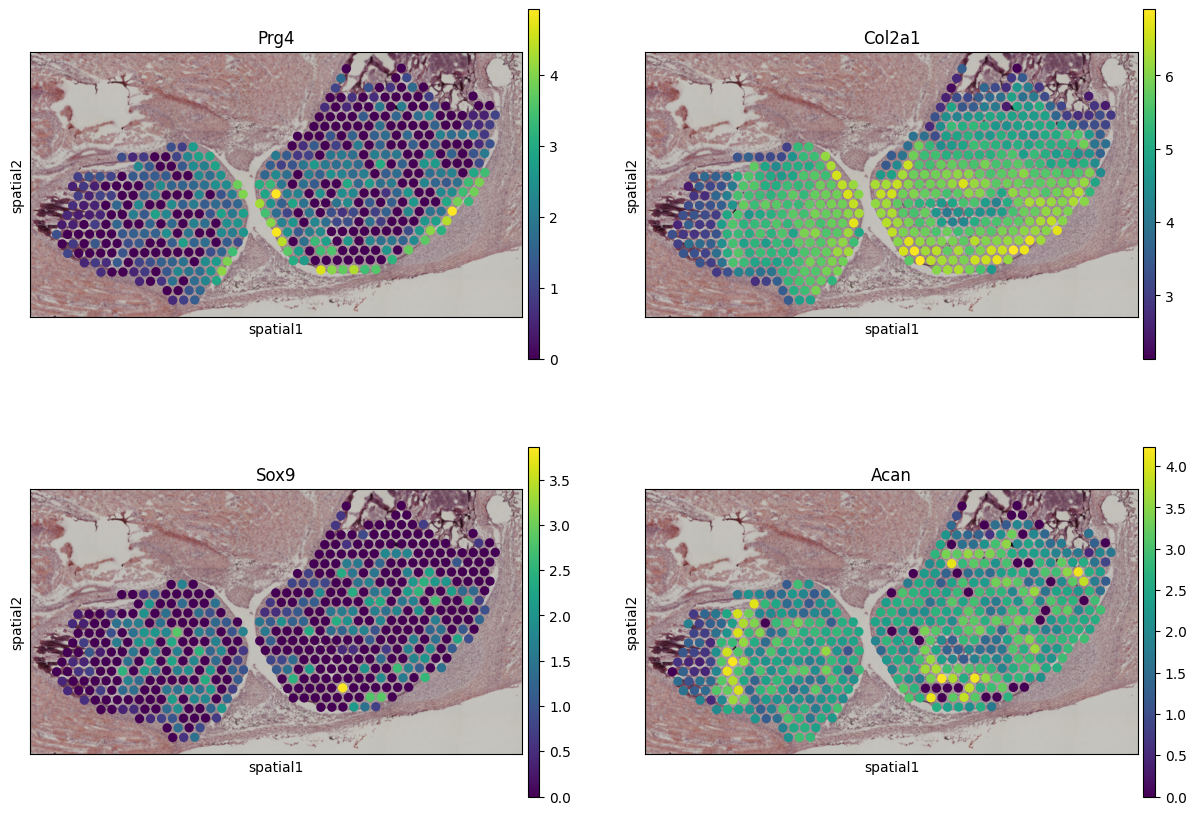

In [296]:
sc.pl.spatial(
    adata,
    color=selected_genes,
    img_key="hires",
    ncols=2,
    size=1.3,
    save="_selected_genes_spatial.png"
)


Expert Annotation and Louvain Clustering

In [297]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Use consistent color palettes for categorical groupings
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

# Get expert annotation and cluster levels
expert_labels = adata.obs["Expert_Annotation"].astype("category").cat.categories
cluster_labels = adata.obs["louvain"].astype("category").cat.categories

# Use Set3 palette (like RColorBrewer::brewer.pal)
set3_colors = sns.color_palette("Set3", n_colors=max(len(expert_labels), len(cluster_labels)))
expert_colors = dict(zip(expert_labels, set3_colors[:len(expert_labels)]))
cluster_colors = dict(zip(cluster_labels, set3_colors[:len(cluster_labels)]))


Plot 1: Expert Annotations

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\807553752.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


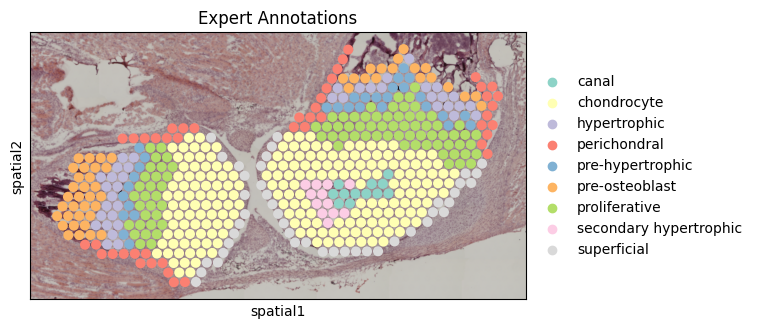

In [298]:
sc.pl.spatial(
    adata,
    color="Expert_Annotation",
    img_key="hires",
    size=1.4,
    palette=expert_colors,
    title="Expert Annotations",
    legend_loc='right margin',
    show=True
)


Plot 2: Automated Clusters

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\3542674842.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


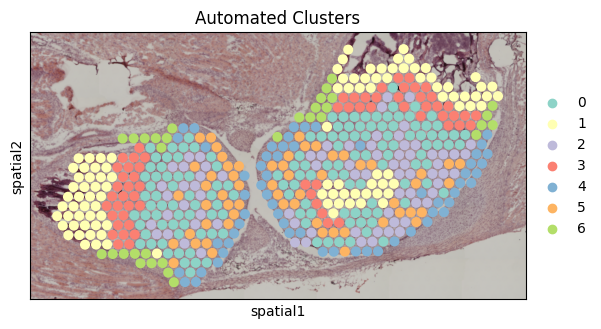

In [299]:
sc.pl.spatial(
    adata,
    color="louvain",
    img_key="hires",
    size=1.4,
    palette=cluster_colors,
    title="Automated Clusters",
    legend_loc='right margin',
    show=True
)


1. Import Required Library

In [300]:
from sklearn.metrics import adjusted_rand_score

2. Extract Clustering Labels

In [301]:
# Ensure both annotations are categorical strings
expert_labels = adata.obs["Expert_Annotation"].astype(str)
auto_labels = adata.obs["louvain"].astype(str)  # or adata.obs["cluster"]


3. Compute Adjusted Rand Index (ARI)

In [302]:
# Compute ARI: agreement between expert and unsupervised clustering
ari_score = adjusted_rand_score(expert_labels, auto_labels)
print(f"Adjusted Rand Index: {ari_score:.3f}")


Adjusted Rand Index: 0.275


4. Side-by-side Spatial Plots

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\1807255354.py:7: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(
C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\1807255354.py:19: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


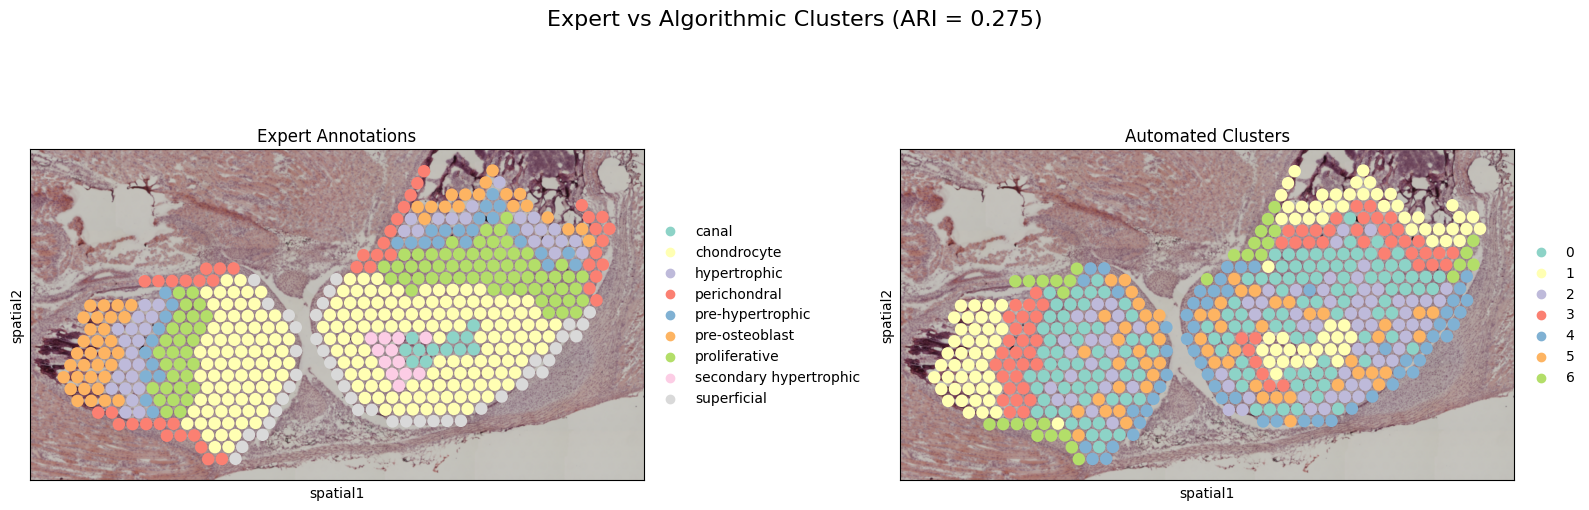

In [303]:
import matplotlib.pyplot as plt

# Create figure with 2 spatial plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Expert Annotations
sc.pl.spatial(
    adata,
    color="Expert_Annotation",
    img_key="hires",
    size=1.4,
    title="Expert Annotations",
    legend_loc='right margin',
    ax=axes[0],
    show=False
)

# Automated Clusters
sc.pl.spatial(
    adata,
    color="louvain", 
    img_key="hires",
    size=1.4,
    title="Automated Clusters",
    legend_loc='right margin',
    ax=axes[1],
    show=False
)

plt.suptitle(f"Expert vs Algorithmic Clusters (ARI = {ari_score:.3f})", fontsize=16)
plt.tight_layout()
plt.show()


### Adjusted Rand Index (ARI)

- ARI quantifies the similarity between two clusterings, correcting for chance.
- An ARI of **1.0** indicates perfect agreement; **0.0** indicates random agreement.
- In this analysis, ARI compares:
  - **Expert_Annotation**: biologically informed tissue labels.
  - **Louvain Clusters**: unsupervised gene expression clusters.
- The spatial plots help visually interpret alignment and discrepancies.


Export Figures

Provided code explicitly saves figures for use in my poster presentation.

In [304]:
# Save combined spatial cluster comparison
fig.savefig("results_Python/figures/Expert_vs_Automated_Clusters.png", dpi=300, bbox_inches='tight')


2. Save Marker Spatial Feature Plots

C:\Users\abuhu\AppData\Local\Temp\ipykernel_9580\918333882.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


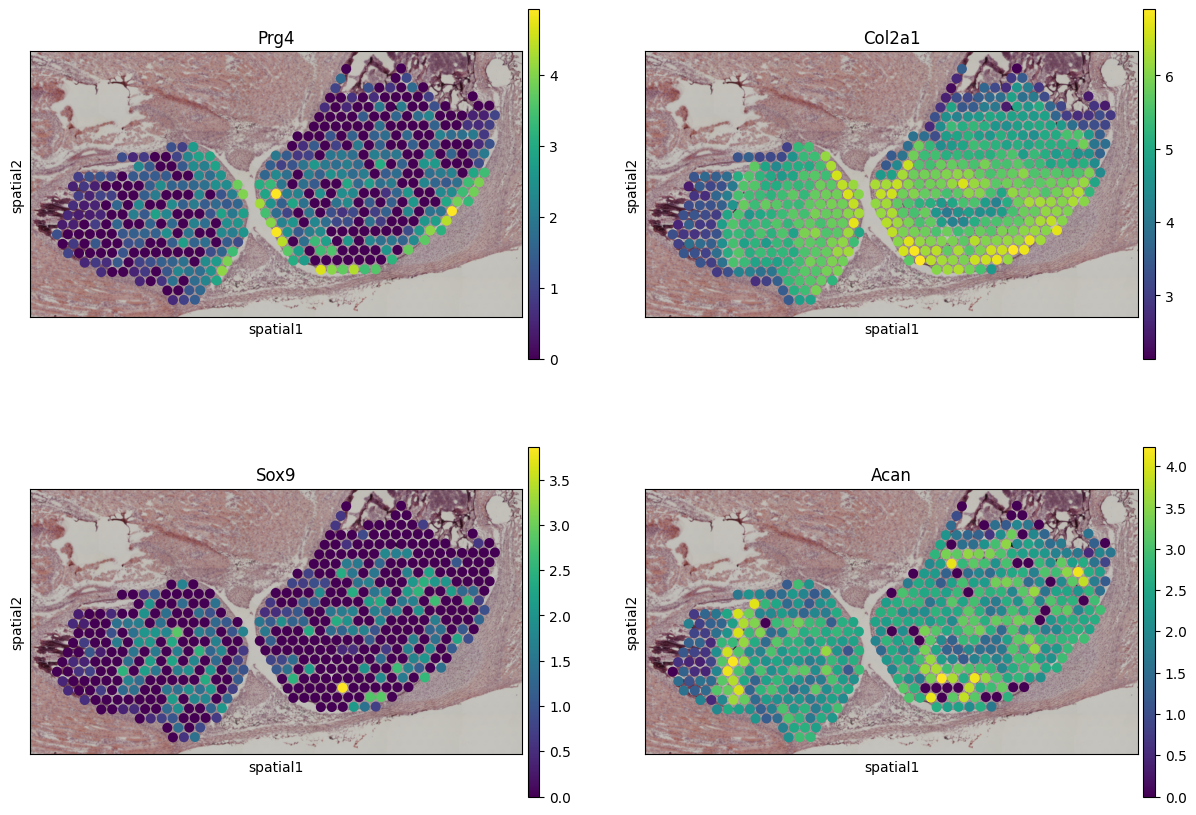

In [305]:
# Re-generate or reuse your spatial marker plots
sc.pl.spatial(
    adata,
    color=["Prg4", "Col2a1", "Sox9", "Acan"],
    img_key="hires",
    ncols=2,
    size=1.4,
    save="_Selected_Marker_Spatial_Features.png"  # Saves in `figures/` if configured
)


3. Prepare DEG Table With Significance Annotation

In [306]:
import pandas as pd
import numpy as np

# Add significance flags
degs["sig"] = np.where(
    (degs["pvals_adj"] < 0.05) & (np.abs(degs["logfoldchanges"]) > 0.5),
    "Significant", "Not Significant"
)

# Optional: strip numeric suffixes from gene names
degs["gene_base"] = degs["names"].str.replace(r"\.\d+$", "", regex=True)


4. Generate Volcano Plots Per Expert Annotation Cluster

In [307]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from adjustText import adjust_text

# Ensure output folder exists
os.makedirs("results_Python/figures", exist_ok=True)

# PDF output path
pdf_path = "results_Python/figures/All_Cluster_Volcano_Plots_Adjusted.pdf"

# Generate volcano plots with non-overlapping labels
with PdfPages(pdf_path) as pdf:
    for cluster in degs["group"].unique():
        cluster_deg = degs[degs["group"] == cluster].copy()

        # Select top 5 significant genes
        top_genes = (
            cluster_deg[cluster_deg["sig"] == "Significant"]
            .sort_values("pvals_adj")
            .head(5)
        )

        # Volcano plot
        plt.figure(figsize=(6, 5))
        ax = sns.scatterplot(
            data=cluster_deg,
            x="logfoldchanges",
            y=-np.log10(cluster_deg["pvals_adj"]),
            hue="sig",
            palette={"Significant": "red", "Not Significant": "gray"},
            edgecolor=None,
            s=20
        )

        # Add non-overlapping labels for top genes
        texts = []
        for _, row in top_genes.iterrows():
            x = row["logfoldchanges"]
            y = -np.log10(row["pvals_adj"])
            texts.append(ax.text(x, y, row["gene_base"], fontsize=9))

        adjust_text(
            texts,
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
            expand_text=(1.1, 1.3)
        )

        # Title and formatting
        plt.title(f"Volcano Plot: {cluster}")
        plt.xlabel("log2 Fold Change")
        plt.ylabel("-log10 Adjusted P-value")
        plt.legend(title="Significance")
        plt.tight_layout()

        # Save this plot page into the PDF
        pdf.savefig()
        plt.close()

print(f"✅ Volcano plots PDF with clear labels saved to:\n{pdf_path}")


✅ Volcano plots PDF with clear labels saved to:
results_Python/figures/All_Cluster_Volcano_Plots_Adjusted.pdf
